# K-NN in python

## 1- Load the required modeules

In [12]:
import numpy as np   
import pandas as pd
import matplotlib.pyplot as plt        
import sklearn                         
import sklearn.datasets as ds            
import sklearn.model_selection as cv   
import sklearn.neighbors as nb           
%matplotlib inline                     

## 2- Load the data

In [13]:
data = pd.read_csv('../datasets/preprocessed/train.csv', sep=',')
Y = data['SalePrice'].to_numpy()
X = data.select_dtypes(include=['float64','int64']).to_numpy() # only numerical

print(X.shape)

(1438, 22)


## 3- Simple cross-validation

In [14]:
# Let's do a simple cross-validation: split data into training and test sets (test 30% of data)
(X_train, X_test,  y_train, y_test) = cv.train_test_split(X, Y, test_size=.3, random_state=1)

# Create a kNN classifier object
knc = nb.KNeighborsClassifier()

# Train the classifier
knc.fit(X_train, y_train)

# Obtain accuracy score of learned classifier on test data
print(knc.score(X_test, y_test))



0.7245370370370371


In [4]:
# More information with confussion matrix
from sklearn.metrics import confusion_matrix

y_pred = knc.predict(X_test)
print(sklearn.metrics.confusion_matrix(y_test, y_pred))

[[70 22  4  0  0]
 [28 50 15  3  0]
 [ 6 35 57 25  0]
 [ 1  3 27 37  4]
 [ 0  1  2 18 24]]


In [5]:
# Obtain Recall, Precision and F-Measure for each class
from sklearn import metrics

print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Level1       0.67      0.73      0.70        96
      Level2       0.45      0.52      0.48        96
      Level3       0.54      0.46      0.50       123
      Level4       0.45      0.51      0.48        72
      Level5       0.86      0.53      0.66        45

    accuracy                           0.55       432
   macro avg       0.59      0.55      0.56       432
weighted avg       0.57      0.55      0.55       432



## 4- Let's do a 10-fold cross-validation

In [6]:
# Method 1
from sklearn.model_selection import cross_val_score  
from sklearn.model_selection import cross_val_predict  
from sklearn.metrics import accuracy_score

cv_scores = cross_val_score(nb.KNeighborsClassifier(),  
                            X=X,  
                            y=Y,  
                            cv=10, scoring='accuracy')  

# cv_scores is a list with 10 accuracies (one for each validation)
print(cv_scores)

[0.54166667 0.54861111 0.57638889 0.59027778 0.57638889 0.60416667
 0.56944444 0.63888889 0.56643357 0.57342657]


In [25]:
# Let's get the mean of the 10 validations (and standard deviation of them)
print(np.mean(cv_scores))
print(np.std(cv_scores))

0.34424533799533796
0.02434237698451611


In [7]:
# Method 2
# Build confussion matrix of all 10 cross-validations
predicted = cross_val_predict(nb.KNeighborsClassifier(), X=X, y=Y,  cv=10)  

print(sklearn.metrics.confusion_matrix(Y, predicted))
print(sklearn.metrics.accuracy_score(Y, predicted))

[[210  79  12   0   0]
 [ 95 157  56   5   0]
 [ 32  83 235  54   0]
 [  4   9 107 131  20]
 [  0   0  10  40  99]]
0.5785813630041725


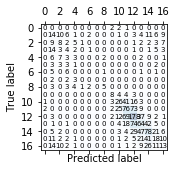

In [30]:
confmat = sklearn.metrics.confusion_matrix(Y, predicted)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center',fontsize=7)

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.savefig('ConMatrix.png', dpi=600)
plt.show()

In [31]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Level1       0.00      0.00      0.00         2
     Level10       0.20      0.38      0.26        16
     Level11       0.00      0.00      0.00        12
     Level12       0.14      0.07      0.10        14
     Level13       0.17      0.25      0.20         4
     Level14       0.00      0.00      0.00         3
     Level15       0.00      0.00      0.00         8
     Level16       0.00      0.00      0.00         0
     Level17       0.00      0.00      0.00         4
      Level2       0.14      0.17      0.15         6
      Level3       0.34      0.34      0.34        29
      Level4       0.38      0.39      0.38        59
      Level5       0.45      0.61      0.52        96
      Level6       0.26      0.18      0.21        60
      Level7       0.47      0.41      0.44        63
      Level8       0.27      0.25      0.26        32
      Level9       0.05      0.04      0.05        24

    accuracy              

/home/ferran/Documents/uni/MD/LAB/DataMiningHousePrices/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ferran/Documents/uni/MD/LAB/DataMiningHousePrices/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### [Optional] Let's see how ammount of training data influences accuracy 

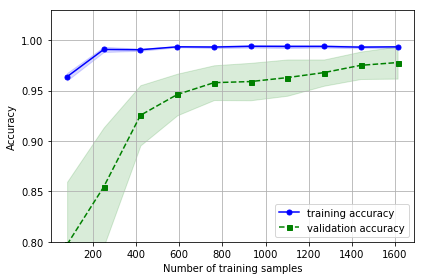

In [13]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=nb.KNeighborsClassifier(n_neighbors=3),
                               X=X,
                               y=y,
                               train_sizes=np.linspace(0.05, 1.0, 10),
                               cv=10,
                               n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid(True)
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.savefig('learning_curve.png', dpi=600)
plt.show()

## 5- Finding parameters for k-NN

In [8]:
# See parameters in
# http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

# Results with different parameters: k
cv_scores = cross_val_score(nb.KNeighborsClassifier(n_neighbors=1), X=X_train, y=y_train,  cv=10)  
print("Accuracy 1 neighbour:", np.mean(cv_scores))

cv_scores = cross_val_score(nb.KNeighborsClassifier(n_neighbors=3), X=X_train, y=y_train,  cv=10)  
print("Accuracy 3 neighbours:",  np.mean(cv_scores))

cv_scores = cross_val_score(nb.KNeighborsClassifier(n_neighbors=5), X=X_train, y=y_train,  cv=10)  
print("Accuracy 5 neighbours:",  np.mean(cv_scores))

cv_scores = cross_val_score(nb.KNeighborsClassifier(n_neighbors=7), X=X_train, y=y_train,  cv=10)  
print("Accuracy 7 neighbours:",  np.mean(cv_scores))

cv_scores = cross_val_score(nb.KNeighborsClassifier(n_neighbors=9), X=X_train, y=y_train,  cv=10)  
print("Accuracy 9 neighbours:",  np.mean(cv_scores))

Accuracy 1 neighbour: 0.5426831683168316
Accuracy 3 neighbours: 0.5506138613861387
Accuracy 5 neighbours: 0.5645247524752476
Accuracy 7 neighbours: 0.5575445544554455
Accuracy 9 neighbours: 0.5535841584158416


In [9]:
# Results with different parameters: k and distance weighting
cv_scores = cross_val_score(nb.KNeighborsClassifier(n_neighbors=1,weights='distance'), X=X_train, y=y_train,  cv=10)  
print("Accuracy 1 neighbour: and distance weighting:", np.mean(cv_scores))

cv_scores = cross_val_score(nb.KNeighborsClassifier(n_neighbors=3,weights='distance'), X=X_train, y=y_train,  cv=10)  
print("Accuracy 3 neighbour: and distance weighting:", np.mean(cv_scores))

cv_scores = cross_val_score(nb.KNeighborsClassifier(n_neighbors=5,weights='distance'), X=X_train, y=y_train,  cv=10)  
print("Accuracy 5 neighbour: and distance weighting:", np.mean(cv_scores))

cv_scores = cross_val_score(nb.KNeighborsClassifier(n_neighbors=7,weights='distance'), X=X_train, y=y_train,  cv=10)  
print("Accuracy 7 neighbour: and distance weighting:", np.mean(cv_scores))

cv_scores = cross_val_score(nb.KNeighborsClassifier(n_neighbors=9,weights='distance'), X=X_train, y=y_train,  cv=10)  
print("Accuracy 9 neighbour: and distance weighting:", np.mean(cv_scores))

Accuracy 1 neighbour: and distance weighting: 0.5426831683168316
Accuracy 3 neighbour: and distance weighting: 0.5596039603960397
Accuracy 5 neighbour: and distance weighting: 0.5715346534653465
Accuracy 7 neighbour: and distance weighting: 0.5665049504950496
Accuracy 9 neighbour: and distance weighting: 0.5665544554455446


### Authomatically find best parameters:

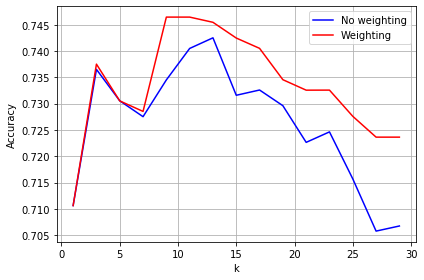

In [15]:
lr = []
for ki in range(1,30,2):
    cv_scores = cross_val_score(nb.KNeighborsClassifier(n_neighbors=ki), X=X_train, y=y_train, cv=10)
    lr.append(np.mean(cv_scores))
plt.plot(range(1,30,2),lr,'b',label='No weighting')

lr = []
for ki in range(1,30,2):
    cv_scores = cross_val_score(nb.KNeighborsClassifier(n_neighbors=ki,weights='distance'), X=X_train, y=y_train, cv=10)
    lr.append(np.mean(cv_scores))
plt.plot(range(1,30,2),lr,'r',label='Weighting')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.grid()
plt.tight_layout()

plt.show()

### Do the same using Grid Search method in python

In [11]:
from sklearn.model_selection import GridSearchCV
params = {'n_neighbors':list(range(1,30,2)), 'weights':('distance','uniform')}
knc = nb.KNeighborsClassifier()
clf = GridSearchCV(knc, param_grid=params,cv=10,n_jobs=-1)  # If cv is integer, by default is Stratifyed 
clf.fit(X_train, y_train)
print("Best Params=",clf.best_params_, "Accuracy=", clf.best_score_)

Best Params= {'n_neighbors': 5, 'weights': 'distance'} Accuracy= 0.5715346534653465


Apply models with best parameters found trained with all training data to the test set

In [18]:
parval=clf.best_params_
knc = nb.KNeighborsClassifier(n_neighbors=parval['n_neighbors'],weights=parval['weights'])
knc.fit(X_train, y_train)
pred=knc.predict(X_test)
print(sklearn.metrics.confusion_matrix(y_test, pred))
print(sklearn.metrics.accuracy_score(y_test, pred))

[[59  0  0  0  0  0  0  0  0  0]
 [ 0 49  0  0  0  0  0  0  0  0]
 [ 0  0 48  0  0  0  0  1  0  0]
 [ 0  0  0 64  0  0  0  0  0  0]
 [ 0  0  0  0 61  0  0  0  0  0]
 [ 0  0  0  0  0 46  0  0  0  1]
 [ 0  0  0  0  0  0 51  0  0  0]
 [ 0  0  0  0  0  0  0 56  0  1]
 [ 0  1  0  0  0  0  0  0 45  0]
 [ 0  0  0  0  0  1  0  0  0 56]]
0.990740740741


In [19]:
# interval confidence
from statsmodels.stats.proportion import proportion_confint

epsilon = sklearn.metrics.accuracy_score(y_test, pred)
print("Can approximate by Normal Distribution?: ",X_test.shape[0]*epsilon*(1-epsilon)>5)
print("Interval 95% confidence:", "{0:.3f}".format(epsilon), "+/-", "{0:.3f}".format(1.96*np.sqrt(epsilon*(1-epsilon)/X_test.shape[0])))
# or equivalent 
proportion_confint(count=epsilon*X_test.shape[0], nobs=X_test.shape[0], alpha=0.05, method='normal')

Can approximate by Normal Distribution?:  False
Interval 95% confidence: 0.991 +/- 0.008


(0.98266245251249873, 0.99881902896898267)

In [20]:
#Using Binomial distribution

proportion_confint(count=epsilon*X_test.shape[0], nobs=X_test.shape[0], alpha=0.05, method='binom_test')

(0.9781611871249579, 0.9963446921115061)

### Mcnemar's Test implementation

In [21]:
# Build two classifiers

# Classifier 1 (3 Neighbours) successes
y_pred = cross_val_predict(nb.KNeighborsClassifier(n_neighbors=3), X=X, y=y,  cv=10) 
res1=np.zeros(y.shape)
res1[y_pred==y]=1

# Classifier 2 (7 Neighbours) 2 successes
y_pred = cross_val_predict(nb.KNeighborsClassifier(n_neighbors=7), X=X, y=y,  cv=10) 
res2=np.zeros(y.shape)
res2[y_pred==y]=1

# Build contingency matrix
n00 = np.sum([res1[res2==1]==1])
n11 = np.sum([res1[res2==0]==0])
n10 = np.sum([res1[res2==1]==0])
n01 = np.sum([res1[res2==0]==1])

# Chi -square test
print("Have the classifiers significant different accuracy?:",(np.abs(n01-n10)-1)**2/(n01+n10)>3.84)

Have the classifiers significant different accuracy?: True


### Take a look to the errors in test set

Guess: 9 Reality: 7


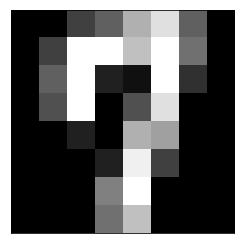

Guess: 7 Reality: 2


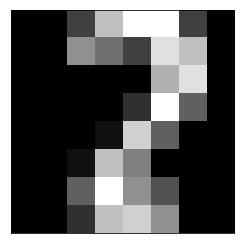

Guess: 9 Reality: 5


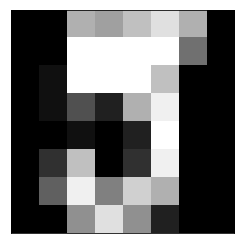

Guess: 1 Reality: 8


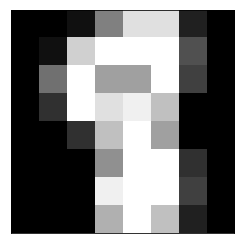

Guess: 5 Reality: 9


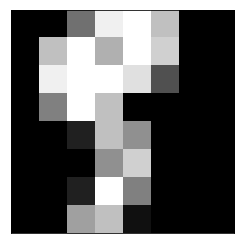

In [22]:
testerrors=[i for i,k in enumerate(pred) if k!=y_test[i]]
plt.gray()
plt.ion
for i in testerrors:
    plt.matshow(X_test[i].reshape(8,8))
    plt.xticks([]); plt.yticks([]);
    print("Guess:", pred[i],"Reality:",y_test[i])
    plt.show()

# Exercises:

### Do a 10-fold Cross-Validation using Naive Bayes

In [23]:
from sklearn.naive_bayes import GaussianNB  # For numerical featuresm assuming normal distribution
from sklearn.naive_bayes import MultinomialNB  # For features with counting numbers (f.i. hown many times word appears in doc)
from sklearn.naive_bayes import BernoulliNB  # For binari features (f.i. word appears or not in document)

# No parameters to tune

clf = GaussianNB()
pred = clf.fit(X_train, y_train).predict(X_test)
print(sklearn.metrics.confusion_matrix(y_test, pred))
print()
print("Accuracy:", sklearn.metrics.accuracy_score(y_test, pred))
print()
print(metrics.classification_report(y_test, pred))
epsilon = sklearn.metrics.accuracy_score(y_test, pred)
proportion_confint(count=epsilon*X_test.shape[0], nobs=X_test.shape[0], alpha=0.05, method='binom_test')

[[54  1  0  0  3  0  0  1  0  0]
 [ 0 42  1  0  0  0  0  0  6  0]
 [ 0  5 32  0  0  0  0  0 12  0]
 [ 0  2  2 51  0  1  0  3  5  0]
 [ 1  4  0  0 54  0  0  1  1  0]
 [ 0  2  0  1  0 41  0  2  1  0]
 [ 0  0  0  0  0  0 51  0  0  0]
 [ 0  0  0  0  0  0  0 57  0  0]
 [ 0 10  0  1  0  0  0  1 34  0]
 [ 0  2  0  1  2  3  1  7  8 33]]

Accuracy: 0.831481481481

             precision    recall  f1-score   support

          0       0.98      0.92      0.95        59
          1       0.62      0.86      0.72        49
          2       0.91      0.65      0.76        49
          3       0.94      0.80      0.86        64
          4       0.92      0.89      0.90        61
          5       0.91      0.87      0.89        47
          6       0.98      1.00      0.99        51
          7       0.79      1.00      0.88        57
          8       0.51      0.74      0.60        46
          9       1.00      0.58      0.73        57

avg / total       0.87      0.83      0.83       540



(0.7973917698694923, 0.861327901247561)

### Reproduce in Rapidminer

In [24]:
# Export data to Rapidminer

import pandas as pd 
df = pd.DataFrame(np.c_[ digits.data, digits.target])
df.to_csv("digits2.csv",index=False)

# Go to Rapidminer and load the data set. Reproduce grid Search there and report results on the test set

### Play with noise

In [25]:
# Lets' add noise to data: 64 new columns with random data
nrcols=64
col = np.random.randint(0,17,(X_train.data.shape[0],nrcols))
col

array([[12, 12, 11, ...,  1, 12,  6],
       [12,  4, 14, ...,  7,  1,  6],
       [ 0,  3,  2, ...,  4, 10, 15],
       ..., 
       [ 4,  6,  2, ...,  9, 12,  1],
       [12,  9,  6, ..., 10,  3,  3],
       [ 8,  1,  8, ...,  0,  3,  7]])

In [26]:
Xr=np.hstack((X_train,col))
Xr

array([[  0.,   0.,   2., ...,   1.,  12.,   6.],
       [  0.,   0.,   3., ...,   7.,   1.,   6.],
       [  0.,   0.,   6., ...,   4.,  10.,  15.],
       ..., 
       [  0.,   0.,   7., ...,   9.,  12.,   1.],
       [  0.,   0.,   0., ...,  10.,   3.,   3.],
       [  0.,   0.,   8., ...,   0.,   3.,   7.]])

In [27]:
col = np.random.randint(0,17,(X_test.data.shape[0],nrcols))
Xr_test=np.hstack((X_test,col))

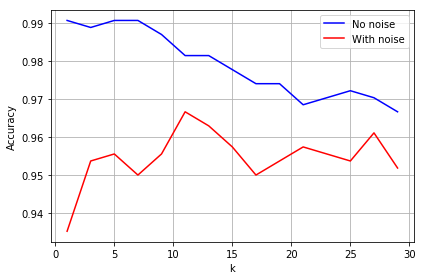

In [28]:
lr = []
for ki in range(1,30,2):
    knc = nb.KNeighborsClassifier(n_neighbors=ki)
    knc.fit(X_train, y_train)
    lr.append(knc.score(X_test, y_test))         
plt.plot(range(1,30,2),lr,'b',label='No noise')

lr = []
for ki in range(1,30,2):
    knc = nb.KNeighborsClassifier(n_neighbors=ki)
    knc.fit(Xr, y_train)
    lr.append(knc.score(Xr_test, y_test))  
plt.plot(range(1,30,2),lr,'r',label='With noise')

plt.xlabel('k')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.grid()
plt.tight_layout()

plt.show()

In [29]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif

fs = SelectKBest(mutual_info_classif, k=64).fit(Xr, y_train) #chi2
X_new = fs.transform(Xr)
Xtr_new = fs.transform(Xr_test)

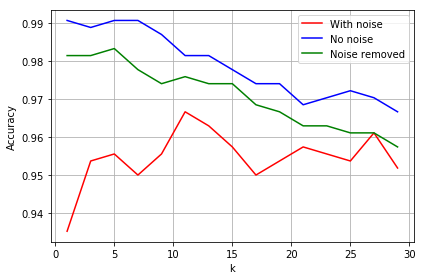

In [30]:
lr = []
for ki in range(1,30,2):
    knc = nb.KNeighborsClassifier(n_neighbors=ki)
    knc.fit(Xr, y_train)
    lr.append(knc.score(Xr_test, y_test))    
plt.plot(range(1,30,2),lr,'r',label='With noise')

lr = []
for ki in range(1,30,2):
    knc = nb.KNeighborsClassifier(n_neighbors=ki)
    knc.fit(X_train, y_train)
    lr.append(knc.score(X_test, y_test))   
plt.plot(range(1,30,2),lr,'b',label='No noise')

lr = []
for ki in range(1,30,2):
    knc = nb.KNeighborsClassifier(n_neighbors=ki)
    knc.fit(X_new, y_train)
    lr.append(knc.score(Xtr_new, y_test))   
plt.plot(range(1,30,2),lr,'g',label='Noise removed')

plt.xlabel('k')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.grid()
plt.tight_layout()

plt.show()

### Change the scorer function

In [34]:
#Let's try to optimize parameters for precision of class "9"

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import make_scorer

params = {'n_neighbors':list(range(1,30,2)), 'weights':('distance','uniform')}
knc = nb.KNeighborsClassifier()
clf = GridSearchCV(knc, param_grid=params,cv=10,n_jobs=-1,scoring="accuracy") 
clf.fit(X_train, y_train)
print("Best Params=",clf.best_params_, "Accuracy=", clf.best_score_)

parval=clf.best_params_
knc = nb.KNeighborsClassifier(n_neighbors=parval['n_neighbors'],weights=parval['weights'])
knc.fit(X_train, y_train)
pred=knc.predict(X_test)
print(sklearn.metrics.confusion_matrix(y_test, pred))
print(sklearn.metrics.accuracy_score(y_test, pred))
print(metrics.classification_report(y_test, pred))

print('Precision for "9": %.3f' % precision_score(y_true=y_test, y_pred=pred,average='macro',labels=[9]))

Best Params= {'n_neighbors': 3, 'weights': 'distance'} Accuracy= 0.984089101034
[[59  0  0  0  0  0  0  0  0  0]
 [ 0 49  0  0  0  0  0  0  0  0]
 [ 0  0 48  0  0  0  0  1  0  0]
 [ 0  0  0 64  0  0  0  0  0  0]
 [ 0  0  0  0 61  0  0  0  0  0]
 [ 0  0  0  0  0 46  0  0  0  1]
 [ 0  0  0  0  0  0 51  0  0  0]
 [ 0  0  0  0  0  0  0 56  0  1]
 [ 0  1  0  0  0  0  0  0 45  0]
 [ 0  0  0  0  0  1  0  0  0 56]]
0.990740740741
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        59
          1       0.98      1.00      0.99        49
          2       1.00      0.98      0.99        49
          3       1.00      1.00      1.00        64
          4       1.00      1.00      1.00        61
          5       0.98      0.98      0.98        47
          6       1.00      1.00      1.00        51
          7       0.98      0.98      0.98        57
          8       1.00      0.98      0.99        46
          9       0.97      0.98      0.97 

In [35]:
# Precison of class 9 is low compared with others. 
# Assume precision of "9" is critical. Let's change optimize parameters by defining precision for 9.

scorer = make_scorer(precision_score,average='macro',labels=[9])
#scorer = make_scorer(score_func=precision_score, pos_label=9, greater_is_better=True,average='micro')


params = {'n_neighbors':list(range(1,30,2)), 'weights':('distance','uniform')}
knc = nb.KNeighborsClassifier()
clf = GridSearchCV(knc, param_grid=params,cv=10,n_jobs=-1,scoring=scorer) 
clf.fit(X_train, y_train)
print("Best Params=",clf.best_params_, "Precision=", clf.best_score_)

parval=clf.best_params_
knc = nb.KNeighborsClassifier(n_neighbors=parval['n_neighbors'],weights=parval['weights'])
knc.fit(X_train, y_train)
pred=knc.predict(X_test)
print(sklearn.metrics.confusion_matrix(y_test, pred))
print(sklearn.metrics.accuracy_score(y_test, pred))
print(metrics.classification_report(y_test, pred))


Best Params= {'n_neighbors': 7, 'weights': 'distance'} Precision= 0.98507697553
[[58  0  0  0  1  0  0  0  0  0]
 [ 0 49  0  0  0  0  0  0  0  0]
 [ 0  0 48  0  0  0  0  1  0  0]
 [ 0  0  0 64  0  0  0  0  0  0]
 [ 0  0  0  0 61  0  0  0  0  0]
 [ 0  0  0  0  0 46  0  0  0  1]
 [ 0  0  0  0  0  0 51  0  0  0]
 [ 0  0  0  0  0  0  0 57  0  0]
 [ 0  1  0  0  0  0  0  0 45  0]
 [ 0  0  0  0  0  1  0  0  0 56]]
0.990740740741
             precision    recall  f1-score   support

          0       1.00      0.98      0.99        59
          1       0.98      1.00      0.99        49
          2       1.00      0.98      0.99        49
          3       1.00      1.00      1.00        64
          4       0.98      1.00      0.99        61
          5       0.98      0.98      0.98        47
          6       1.00      1.00      1.00        51
          7       0.98      1.00      0.99        57
          8       1.00      0.98      0.99        46
          9       0.98      0.98      0.98 

Guess: 4 Reality: 0


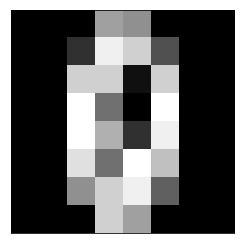

Guess: 7 Reality: 2


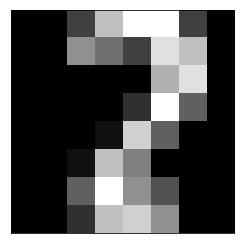

Guess: 9 Reality: 5


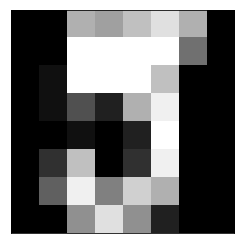

Guess: 1 Reality: 8


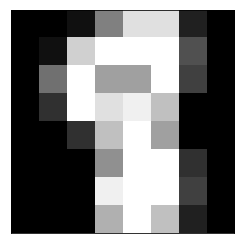

Guess: 5 Reality: 9


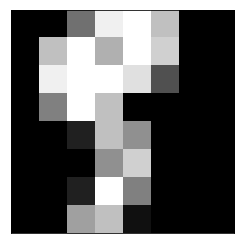

In [36]:
testerrors=[i for i,k in enumerate(pred) if k!=y_test[i]]
plt.gray()
plt.ion
for i in testerrors:
    plt.matshow(X_test[i].reshape(8,8))
    plt.xticks([]); plt.yticks([]);
    print("Guess:", pred[i],"Reality:",y_test[i])
    plt.show()